In [109]:
import torch 
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import os
import random
from PIL import Image
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Conclusions and answers:

#### Why randomly initialized network is better?
I know that the weights that are initialized very close to zero, but randomly are very effective in modern NN as it breaks the symmetry and allows for faster learning. I have no idea though why randomly initialized network performs better than random retrieval. Maybe because some weights are aldeady trained?

#### triplet loss + learning rate
I implemented and trained the network with triplet loss and learning rate decay.

The results of training with triplet loss are very impressive and work very good:

- At-least-1-positive@1   : 0.930
- At-least-1-positive@5   : 0.980
- At-least-1-positive@10  : 0.990

However, the results of default convolutional NN are somewhy better and give almost perfect results:
- At-least-1-positive@1   : 0.990
- At-least-1-positive@5   : 1.000
- At-least-1-positive@10  : 1.000


In [110]:
class MNISTtriplets(data.Dataset):
    """
    Load the MNIST dataset in triplets of similar(positive)/non-similar(negative) pairs
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.transform = self.mnist_dataset.transform
        self.labels = self.mnist_dataset.train_labels
        self.data = self.mnist_dataset.train_data
        # indices of images for each class
        self.class_idx = [np.where(self.labels == x)[0] for x in range(0, 10)]

    def __getitem__(self, index):

        # anchor image
        img1, label1 = self.data[index], self.labels[index].item()

        # positive image:
        index2 = index
        while index2 == index:
            index2 = np.random.choice(self.class_idx[label1])
        img2 = self.data[index2]

        # negative image:
        img3 = self.data[np.random.choice(self.class_idx[np.random.choice(np.setdiff1d(range(0, 10), label1))])]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        img3 = Image.fromarray(img3.numpy(), mode='L')

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return (img1, img2, img3)

    def __len__(self):
        return len(self.data)


class MNISTpairs(data.Dataset):
    """
    Load the MNIST dataset in pairs of similar(positive)/non-similar(negative) pairs
    """

    def __init__(self, mnist_dataset):    
        self.mnist_dataset = mnist_dataset
        self.transform = self.mnist_dataset.transform
        self.labels = self.mnist_dataset.train_labels
        self.data = self.mnist_dataset.train_data                
        # indices of images for each class
        self.class_idx = [np.where(self.labels==x)[0] for x in range(0,10)]
    
    def __getitem__(self, index):
        
        # anchor image
        img1, label1 = self.data[index], self.labels[index].item()
        # draw another positive (1) or negative (0) image
        pair_label = np.random.randint(0, 2)
        
        if pair_label == 1:
            # choose an image with the same label as the anchor - avoid itself
            index2 = index
            while index2 == index:
                index2 = np.random.choice(self.class_idx[label1])
            img2 = self.data[index2]
        else:
            # choose an image with the different label than the anchor 
            img2 = self.data[np.random.choice(self.class_idx[ np.random.choice(np.setdiff1d(range(0,10), label1))])]
            
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return (img1, img2), pair_label
    
    def __len__(self):
        return len(self.data)
        
    
# mnist dataset structure - test part
mnist_dataset_test = datasets.MNIST('vs3ex1data/mnist_data', train=False, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ]))
    
# mnist dataset structure - train part
mnist_dataset_train = datasets.MNIST('vs3ex1data/mnist_data', train=True, transform=transforms.Compose([
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
               ]))
            
# mnist dataset in positive/negative pairs structure 
mnist_dataset_train_pairs = MNISTpairs(mnist_dataset_train)

# mnist dataset in positive/negative pairs structure
mnist_dataset_train_triplets = MNISTtriplets(mnist_dataset_train)


In [111]:
def l2n(x, eps=1e-6):
    """
    Vector L2 normalization 
    """
    return x / (torch.norm(x, p=2, dim=1, keepdim=True) + eps).expand_as(x)

class MnistNetEmb(nn.Module):
    """
    Liteweight network architecture for the Mnist dataset (digit) to extract descriptors/embeddings
    """

    def __init__(self):
        super(MnistNetEmb, self).__init__()

        # fully convolutional part
        self.features = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, 4, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True)            
        )
        
        # embedding network, FC layers
        self.embedder = nn.Sequential(
            nn.Linear(16*4,16) # 64 * 16 = 1024
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.embedder(x.view(-1,x.size(-3)*x.size(-2)*x.size(-1)))
        return l2n(x)


In [112]:
def train3(model, train_loader, optimizer, scheduler, margin = 0.9):
    """
    Training of an epoch with Contrastive loss and training pairs
    model: network
    train_loader: train_loader loading pairs of positive/negative images and pair-label in batches. 
    scheduler: scheduler to use in the training
    margin: loss margin
    """

    model.train()
    total_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        # extract descriptor for anchor and the corresponding pos/neg images
        a, p, n = model(data[0]), model(data[1]), model(data[2]) # 64 * 16

        # compute the triplet loss
        d_a_p = (a - p).pow(2).sum(1).sqrt()
        d_a_n = (a - n).pow(2).sum(1).sqrt()

        loss = d_a_p - d_a_n + margin
        loss = torch.clamp(loss, min=0)

        loss.sum().backward()
        optimizer.step()

        total_loss = total_loss + loss.sum().data.numpy()
        
        if batch_idx % 1000 == 0:
            print('[{}/{} ({:.0f}%)]\tBatch loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.mean()))

    scheduler.step()
    print('Epoch average loss {:.6f}'.format(total_loss/len(train_loader.dataset)))


def train2(model, train_loader, optimizer, margin = 0.9):
    """
    Training of an epoch with Contrastive loss and training pairs
    model: network
    train_loader: train_loader loading pairs of positive/negative images and pair-label in batches. 
    optimizer: optimizer to use in the training
    margin: loss margin
    """

    model.train()
    all_neg_dist = torch.Tensor()
    all_pos_dist = torch.Tensor()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # extract descriptor for anchor and the corresponding pos/neg images
        v1, v2 = model(data[0]), model(data[1])
        
        # compute the contrastive loss
        distances = (v2 - v1).pow(2).sum(1).sqrt()        
        loss = 0.5 * (target.float() * distances.pow(2) + (1-target).float()*F.relu(margin - distances).pow(2))
        
        loss.sum().backward()
        optimizer.step()

        all_neg_dist = torch.cat((all_neg_dist, distances[torch.nonzero(1-target)].view(-1))) # for statistics
        all_pos_dist = torch.cat((all_pos_dist, distances[torch.nonzero(target)].view(-1))) # for statistics
        total_loss = total_loss + loss.sum().data.numpy()
        
        if batch_idx % 100 == 0:
            print('[{}/{} ({:.0f}%)]\tBatch loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.mean()))
    print('Epoch average loss {:.6f}'.format(total_loss/len(train_loader.dataset)))

    plt.hist(all_pos_dist.data.numpy(), 20, alpha = 0.5, label = 'pos')
    plt.hist(all_neg_dist.data.numpy(), 20, alpha = 0.5, label = 'neg')
    plt.title('Distribution of distances for positive and negative pairs')
    plt.legend(loc='upper right')
    plt.show()

    
def test(model, test_loader, step = 100):
    """
    Compute accuracy on the test set
    model: network
    test_loader: test_loader loading images and labels in batches
    step: step to iterate over images (for faster evaluation)
    """

    model.eval()
    des = torch.Tensor()
    labels = torch.LongTensor()
    for batch_idx, (data, target) in enumerate(test_loader):
        # print(model(data).shape)
        des = torch.cat((des, model(data)))
        labels = torch.cat((labels, target))
    
    # compute all pair-wise distances
    cdistances = cdist(des.data.numpy(), des.data.numpy(), 'euclidean')
        
    # find rank of closest positive image (using each descriptor as a query)
    minrank_positive = []
    for i in range(0,len(cdistances),step):
        idx = np.argsort(cdistances[i])
        minrank_positive.append( np.min([j for (j,x) in enumerate(labels[idx[1:-1]]) if x==labels[i]]) )
    
    print('At-least-1-positive@1   : {:.3f}'.format((np.array(minrank_positive)<1).mean()))
    print('At-least-1-positive@5   : {:.3f}'.format((np.array(minrank_positive)<5).mean()))
    print('At-least-1-positive@10  : {:.3f}'.format((np.array(minrank_positive)<10).mean()))


In [113]:
# loader of the training set in triplets
train_loader_triplets = torch.utils.data.DataLoader(mnist_dataset_train_triplets, batch_size=64, shuffle=True)

# loader of the training set in pairs
train_loader_pairs = torch.utils.data.DataLoader(mnist_dataset_train_pairs,batch_size=64, shuffle=True)

#loader of the test set (no pairs here)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test,batch_size=512, shuffle=False)

model = MnistNetEmb() # initialize the network

print('Validating the randomly initialized network')
test(model, test_loader) # test the randomly initialized network


Validating the randomly initialized network
At-least-1-positive@1   : 0.640
At-least-1-positive@5   : 0.890
At-least-1-positive@10  : 0.950


why it's better

### Triplet training:

In [85]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.5)


print('Training with Contrastive loss and training pairs')
# train with contrastive loss
contrastive_margin = 0.9
triplet_margin = 1

for epoch in range(1, 10 + 1):
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
        # scheduler.step()
        train3(model, train_loader_triplets, optimizer, scheduler, triplet_margin)
        test(model, test_loader)

Validating the randomly initialized network
Training with Contrastive loss and training pairs
Epoch-1 lr: 0.01
[0/60000 (0%)]	Batch loss: 0.939211
Epoch average loss 0.240939
At-least-1-positive@1   : 0.920
At-least-1-positive@5   : 0.970
At-least-1-positive@10  : 0.970
Epoch-2 lr: 0.01
[0/60000 (0%)]	Batch loss: 0.126694
Epoch average loss 0.182888
At-least-1-positive@1   : 0.930
At-least-1-positive@5   : 0.980
At-least-1-positive@10  : 0.980
Epoch-3 lr: 0.005
[0/60000 (0%)]	Batch loss: 0.159231
Epoch average loss 0.171382
At-least-1-positive@1   : 0.930
At-least-1-positive@5   : 0.970
At-least-1-positive@10  : 0.980
Epoch-4 lr: 0.005
[0/60000 (0%)]	Batch loss: 0.176620
Epoch average loss 0.168304
At-least-1-positive@1   : 0.920
At-least-1-positive@5   : 0.980
At-least-1-positive@10  : 0.990
Epoch-5 lr: 0.0025
[0/60000 (0%)]	Batch loss: 0.131424
Epoch average loss 0.165267
At-least-1-positive@1   : 0.930
At-least-1-positive@5   : 0.980
At-least-1-positive@10  : 0.980
Epoch-6 lr: 0.002

### Usual loss:

Training with Contrastive loss and training pairs
Epoch 1
[0/60000 (0%)]	Batch loss: 0.092597
[200/60000 (11%)]	Batch loss: 0.054290
[400/60000 (21%)]	Batch loss: 0.040197
[600/60000 (32%)]	Batch loss: 0.047341
[800/60000 (43%)]	Batch loss: 0.040686
[1000/60000 (53%)]	Batch loss: 0.034513
[1200/60000 (64%)]	Batch loss: 0.042145
[1400/60000 (75%)]	Batch loss: 0.031831
[1600/60000 (85%)]	Batch loss: 0.038177
[1800/60000 (96%)]	Batch loss: 0.040979
Epoch average loss 0.043725


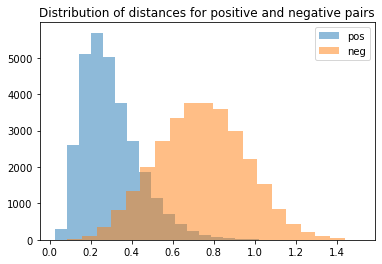

At-least-1-positive@1   : 0.920
At-least-1-positive@5   : 0.980
At-least-1-positive@10  : 0.980
Epoch 2
[0/60000 (0%)]	Batch loss: 0.027705
[200/60000 (11%)]	Batch loss: 0.033245
[400/60000 (21%)]	Batch loss: 0.029160
[600/60000 (32%)]	Batch loss: 0.029497
[800/60000 (43%)]	Batch loss: 0.038605
[1000/60000 (53%)]	Batch loss: 0.026913
[1200/60000 (64%)]	Batch loss: 0.030809
[1400/60000 (75%)]	Batch loss: 0.032289
[1600/60000 (85%)]	Batch loss: 0.026378
[1800/60000 (96%)]	Batch loss: 0.031499
Epoch average loss 0.032698


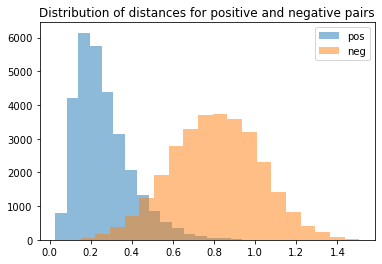

At-least-1-positive@1   : 0.950
At-least-1-positive@5   : 1.000
At-least-1-positive@10  : 1.000
Epoch 3
[0/60000 (0%)]	Batch loss: 0.022498
[200/60000 (11%)]	Batch loss: 0.023314
[400/60000 (21%)]	Batch loss: 0.037358
[600/60000 (32%)]	Batch loss: 0.040971
[800/60000 (43%)]	Batch loss: 0.035615
[1000/60000 (53%)]	Batch loss: 0.027935
[1200/60000 (64%)]	Batch loss: 0.030120
[1400/60000 (75%)]	Batch loss: 0.036824
[1600/60000 (85%)]	Batch loss: 0.042477
[1800/60000 (96%)]	Batch loss: 0.029336
Epoch average loss 0.030180


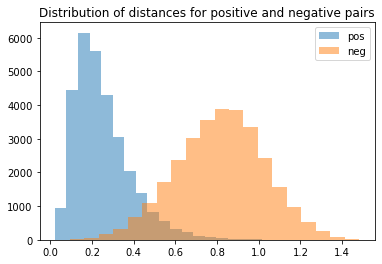

At-least-1-positive@1   : 0.930
At-least-1-positive@5   : 0.990
At-least-1-positive@10  : 1.000
Epoch 4
[0/60000 (0%)]	Batch loss: 0.021839
[200/60000 (11%)]	Batch loss: 0.038095
[400/60000 (21%)]	Batch loss: 0.029950
[600/60000 (32%)]	Batch loss: 0.029116
[800/60000 (43%)]	Batch loss: 0.034555
[1000/60000 (53%)]	Batch loss: 0.027983
[1200/60000 (64%)]	Batch loss: 0.033236
[1400/60000 (75%)]	Batch loss: 0.034659
[1600/60000 (85%)]	Batch loss: 0.020788
[1800/60000 (96%)]	Batch loss: 0.025722
Epoch average loss 0.029083


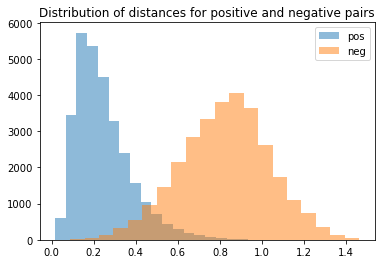

At-least-1-positive@1   : 0.890
At-least-1-positive@5   : 0.980
At-least-1-positive@10  : 1.000
Epoch 5
[0/60000 (0%)]	Batch loss: 0.019396
[200/60000 (11%)]	Batch loss: 0.029882
[400/60000 (21%)]	Batch loss: 0.024929
[600/60000 (32%)]	Batch loss: 0.033731
[800/60000 (43%)]	Batch loss: 0.030412
[1000/60000 (53%)]	Batch loss: 0.033505
[1200/60000 (64%)]	Batch loss: 0.037585
[1400/60000 (75%)]	Batch loss: 0.034129
[1600/60000 (85%)]	Batch loss: 0.028671
[1800/60000 (96%)]	Batch loss: 0.026516
Epoch average loss 0.028214


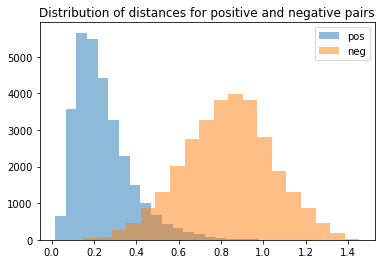

At-least-1-positive@1   : 0.920
At-least-1-positive@5   : 0.970
At-least-1-positive@10  : 0.980
Epoch 6
[0/60000 (0%)]	Batch loss: 0.039264
[200/60000 (11%)]	Batch loss: 0.023428
[400/60000 (21%)]	Batch loss: 0.027780
[600/60000 (32%)]	Batch loss: 0.021272
[800/60000 (43%)]	Batch loss: 0.028564
[1000/60000 (53%)]	Batch loss: 0.026880
[1200/60000 (64%)]	Batch loss: 0.030972
[1400/60000 (75%)]	Batch loss: 0.031057
[1600/60000 (85%)]	Batch loss: 0.023435
[1800/60000 (96%)]	Batch loss: 0.029627
Epoch average loss 0.027894


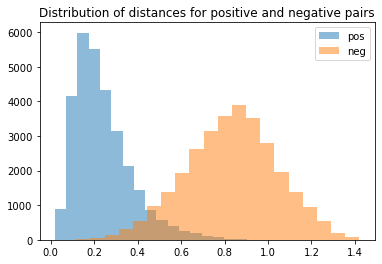

At-least-1-positive@1   : 0.950
At-least-1-positive@5   : 0.990
At-least-1-positive@10  : 1.000
Epoch 7
[0/60000 (0%)]	Batch loss: 0.026206
[200/60000 (11%)]	Batch loss: 0.023160
[400/60000 (21%)]	Batch loss: 0.031006
[600/60000 (32%)]	Batch loss: 0.024212
[800/60000 (43%)]	Batch loss: 0.025921
[1000/60000 (53%)]	Batch loss: 0.024845
[1200/60000 (64%)]	Batch loss: 0.017669
[1400/60000 (75%)]	Batch loss: 0.031178
[1600/60000 (85%)]	Batch loss: 0.026531
[1800/60000 (96%)]	Batch loss: 0.021847
Epoch average loss 0.027297


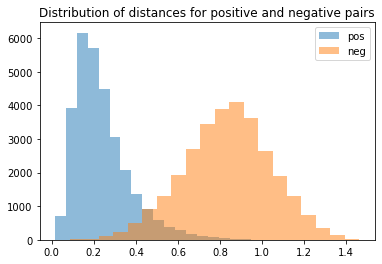

At-least-1-positive@1   : 0.940
At-least-1-positive@5   : 1.000
At-least-1-positive@10  : 1.000
Epoch 8
[0/60000 (0%)]	Batch loss: 0.030913
[200/60000 (11%)]	Batch loss: 0.023692
[400/60000 (21%)]	Batch loss: 0.030593
[600/60000 (32%)]	Batch loss: 0.040227
[800/60000 (43%)]	Batch loss: 0.023806
[1000/60000 (53%)]	Batch loss: 0.025801
[1200/60000 (64%)]	Batch loss: 0.017168
[1400/60000 (75%)]	Batch loss: 0.027537
[1600/60000 (85%)]	Batch loss: 0.020703
[1800/60000 (96%)]	Batch loss: 0.026997
Epoch average loss 0.026960


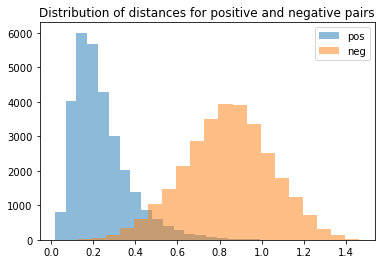

At-least-1-positive@1   : 0.940
At-least-1-positive@5   : 1.000
At-least-1-positive@10  : 1.000
Epoch 9
[0/60000 (0%)]	Batch loss: 0.019187
[200/60000 (11%)]	Batch loss: 0.025977
[400/60000 (21%)]	Batch loss: 0.022027
[600/60000 (32%)]	Batch loss: 0.022965
[800/60000 (43%)]	Batch loss: 0.025597
[1000/60000 (53%)]	Batch loss: 0.032398
[1200/60000 (64%)]	Batch loss: 0.034955
[1400/60000 (75%)]	Batch loss: 0.024034
[1600/60000 (85%)]	Batch loss: 0.027862
[1800/60000 (96%)]	Batch loss: 0.016366
Epoch average loss 0.026666


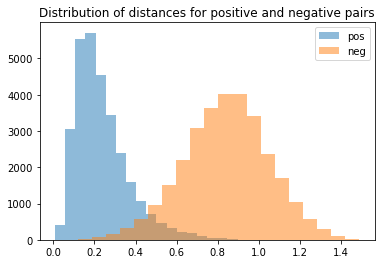

At-least-1-positive@1   : 0.960
At-least-1-positive@5   : 1.000
At-least-1-positive@10  : 1.000
Epoch 10
[0/60000 (0%)]	Batch loss: 0.031016
[200/60000 (11%)]	Batch loss: 0.033562
[400/60000 (21%)]	Batch loss: 0.020488
[600/60000 (32%)]	Batch loss: 0.027376
[800/60000 (43%)]	Batch loss: 0.024582
[1000/60000 (53%)]	Batch loss: 0.021111
[1200/60000 (64%)]	Batch loss: 0.024225
[1400/60000 (75%)]	Batch loss: 0.030806
[1600/60000 (85%)]	Batch loss: 0.026257
[1800/60000 (96%)]	Batch loss: 0.030210
Epoch average loss 0.026313


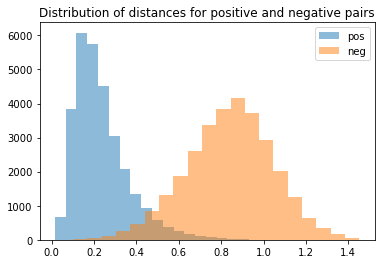

At-least-1-positive@1   : 0.990
At-least-1-positive@5   : 1.000
At-least-1-positive@10  : 1.000


In [102]:
model_pairs = MnistNetEmb() # initialize the network

optimizer = optim.SGD(model_pairs.parameters(), lr=0.001, momentum=0.9)

print('Training with Contrastive loss and training pairs')
# train with contrastive loss
contrastive_margin = 0.9
for epoch in range(1, 10 + 1):
        print('Epoch {}'.format(epoch))
        train2(model_pairs, train_loader_pairs, optimizer, contrastive_margin)
        test(model_pairs, test_loader)